# Importing the required modules

In [1]:
# modules used for data handling and
# manipulation
import numpy as np
import pandas as pd

# modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modules used for encoding and data splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [2]:
flight_df = pd.read_csv("DelayData.csv")

# Initial Data Exploration

In [3]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201664 entries, 0 to 1201663
Data columns (total 61 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1201664 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   scheduleddepartdatetime  1201664 non-null  object 
 3   origin                   1201664 non-null  object 
 4   dest                     1201664 non-null  object 
 5   uniquecarrier            1201664 non-null  object 
 6   marketshareorigin        1201664 non-null  float64
 7   marketsharedest          1201664 non-null  float64
 8   hhiorigin                1201664 non-null  float64
 9   hhidest                  1201664 non-null  float64
 10  nonhubairportorigin      1201664 non-null  int64  
 11  smallhubairportorigin    1201664 non-null  int64  
 12  mediumhubairportorigin   1201664 non-null  int64  
 13  largehubairportorigin    1201664 non-null 

- The dataset has 1201664 rows and 61 columns.
- The dataset is partially pre-processed. Few of the categorical variables are already one-hot encoded.
- However, the many of categorical variables that are already encoded are ordinal in nature and one-hot encoding is not appropriate for it.
- It also appears that the `windspeed` column is transformed into `windspeedsquare`. It must checked which one is better and only one of them must be retained.
- The first five rows of the dataset are shown below.

In [4]:
flight_df.head()

depdelay  arrdelay scheduleddepartdatetime origin dest uniquecarrier  \
0         0      -4.0    08-Jan-2004 15:25:00    ELP  SAT            WN   
1        -4      11.0    22-Jan-2004 14:40:00    ATL  MSY            DL   
2         3      12.0    29-Jan-2004 12:25:00    DFW  JFK            DL   
3        -3      24.0    14-Jan-2004 15:55:00    SEA  EWR            CO   
4         0      -8.0    14-Jan-2004 18:40:00    SLC  RNO            OO   

   marketshareorigin  marketsharedest  hhiorigin   hhidest  ...  \
0           0.618467         0.407567   0.417090  0.226878  ...   
1           0.500757         0.096321   0.319589  0.196657  ...   
2           0.060898         0.131962   0.296126  0.214357  ...   
3           0.040522         0.347744   0.234712  0.249377  ...   
4           0.506899         0.176493   0.341763  0.277364  ...   

   windgustdummy  windgustspeed  raindummy  raintracedummy  snowdummy  \
0              0            0.0          0               0          0   
1              0            0.0          0               0          0   
2              0            0.0          0               0          0   
3              0            0.0          1               0          0   
4              0            0.0          0               0          0   

   snowtracedummy  originmetropop  originmetrogdppercapita  destmetropop  \
0               0          702433                27314.633       1843927   
1               0         4802300                49081.773       1314721   
2               0         5689982                50588.563      18747431   
3               0         3163703                57755.547      18747431   
4               0         1030597                45043.602        385049   

   destmetrogdppercapita  
0              35005.234  
1              48848.234  
2              57295.402  
3              57295.402  
4              49079.727  

[5 rows x 61 columns]

# Data Cleaning

## Handling null values

In [5]:
def display_cols_wt_na(df):
   print(df.isna().sum().loc[lambda x : x>0].sort_values(ascending = False)*100/len(df))

In [6]:
display_cols_wt_na(flight_df)

arrdelay           0.266797
temperature        0.038280
windspeed          0.038280
windspeedsquare    0.038280
windgustspeed      0.038280
dtype: float64


- The `arrdelay` has 0.26% null values. It is also the target column and hence the **rows** with null value for `arrdelay` must be dropped.
- After dropping those rows we will check if the other columns yet have null values.

In [7]:
flight_df = flight_df[flight_df['arrdelay'].notna()]
display_cols_wt_na(flight_df)

temperature        0.038383
windspeed          0.038383
windspeedsquare    0.038383
windgustspeed      0.038383
dtype: float64


- All the columns have 0.03% null values and hence can be imputed.
- Now, we will impute the missing values in the `temperature`, `windspeed`, `windspeedsquare`, and `windgustspeed` with the **mean** of the columns.
- `np.nanmean()` is used to compute mean of columns with null values.

In [8]:
to_impute_cols = ["temperature", "windspeed", "windspeedsquare", "windgustspeed"]

for col in to_impute_cols:
    col_mean = np.nanmean(flight_df[col])
    flight_df[col] = flight_df[col].fillna(col_mean)

In [9]:
display_cols_wt_na(flight_df)

Series([], dtype: float64)


All null values are handled.

## Dropping the columns

- There are few redundant columns and they need dropped.
- The `scheduleddepartdatetime` column stores the timestamp for each flight. However, the dataset also has all the individual components in separate columns and hence this column is dropped.
- The `originairportid` and `destairportid` columns have same information as the `origin` and `dest` columns. Hence, they are dropped.
- The `originstate` and `origincityname` columns have same information as `origin` column. While, this data is unknown for `dest`. Hence, those two columns are dropped.

**Note**: the time-series nature of data is not considered for the modelling.

In [10]:
cols_to_be_dropped = ["scheduleddepartdatetime",
                      "originairportid",
                      "destairportid",
                      "originstate",
                      "origincityname"]

flight_df = flight_df.drop(columns = cols_to_be_dropped,
                           axis = 1)

In [11]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198458 entries, 0 to 1201663
Data columns (total 56 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1198458 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   origin                   1198458 non-null  object 
 3   dest                     1198458 non-null  object 
 4   uniquecarrier            1198458 non-null  object 
 5   marketshareorigin        1198458 non-null  float64
 6   marketsharedest          1198458 non-null  float64
 7   hhiorigin                1198458 non-null  float64
 8   hhidest                  1198458 non-null  float64
 9   nonhubairportorigin      1198458 non-null  int64  
 10  smallhubairportorigin    1198458 non-null  int64  
 11  mediumhubairportorigin   1198458 non-null  int64  
 12  largehubairportorigin    1198458 non-null  int64  
 13  nonhubairportdest        1198458 non-null  int6

# Rectifying incorrectly encoded ordinal categorical variables

As deduced from the initial analysis, there are few columns that are already one-hot encoded in the dataset. However, some of these categorical variables (described below) are ordinal and one-hot encoding is not appropriate for them.

- The columns of the form `temp_<lower-limit>_<upper-limit>` denote the range in which `temperature` falls in. These columns hold 1 if the `temperature` falls in that range and 0 otherwise. However, the ranges have an order associated with them as follows:

  $-\infty$ to $-10 < -10$ to $0 < 0$ to $10 < 10$ to $20 < 20$ to $30 < 30$ to $40 < 40$ to $\infty$

Hence, a single column `temp_range` is created and contains the categories. All the columns already present as a part of one-hot encoding are dropped.

- The columns of the form `<size of hub>airportorigin` and `<size of hub>airportdest` denote whether the origin and destination airports are hubs for some airline and if its a hub what is its size. These columns hold 1 if the `origin` or `dest` is a `<size of hub>` hub for some airline and 0 otherwise.

  nonhub $<$ small $<$ medium $<$ large

Hence, a two columns `hubairportorigin` and `hubairportdest` are created and contains the categories. All the columns already present as a part of one-hot encoding are dropped.

- The columns of the form `<size of hub>airlineorigin` and `<size of hub>airlinedest` denote whether the origin and destination airports are hubs for the airline and if its a hub what is its size. These columns hold 1 if the `origin` or `dest` is a `<size of hub>` hub for `uniquecarrier` and 0 otherwise.

  nonhub $<$ small $<$ medium $<$ large

Hence, a two columns `hubairlineorigin` and `hubairlinedest` are created and contains the categories. All the columns already present as a part of one-hot encoding are dropped.

In [12]:
# extracting all dummy features from the respective categories.
cols = list(flight_df.columns)
temperature_range = cols[37:44]
airport_connectivity_origin = cols[9:13]
airport_connectivity_dest = cols[13:17]
airline_connectivity_origin = cols[17:21]
airline_connectivity_dest = cols[21:25]

In [13]:
# converts dummy columns into a single categorical feature.
def onehot2ordinal(new_colname: str, dummies: list, str2replace: str, sep = None):

    flight_df[new_colname] = pd.from_dummies(flight_df[dummies], 
                           default_category = np.nan,
                           sep = sep)
    if not sep:
       flight_df[new_colname] = flight_df[new_colname].astype(str).apply(lambda x: x.replace(str2replace, 
                                                                                             ''))

    flight_df.drop(dummies, axis = 1, inplace = True)

In [14]:
# applies the function to all the respective kinds of dummy features.
arguments = [["temp_range", temperature_range, None, "_"],
             ["hubairportorigin", airport_connectivity_origin, "airportorigin", None],
             ["hubairportdest", airport_connectivity_dest, "airportdest", None],
             ["hubairlineorigin", airline_connectivity_origin, "airlineorigin", None],
             ["hubairlinedest", airline_connectivity_dest, "airlinedest", None]]

for new_colname, dummies, str2replace, sep in arguments:
    
    onehot2ordinal(new_colname = new_colname, dummies = dummies,
                   str2replace = str2replace, sep = sep)

It appears that `temp_range` has some null values and these can be derived by categorizing the temperature value for the particular row.

In [15]:
def categorise_temp(temp):
    if temp <= -10:
        return "ninfty_n10"
    elif temp > -10 and temp <= 0:
        return "n10_0"
    elif temp > 0 and temp <= 10:
        return "0_10"
    elif temp > 10 and temp <= 20:
        return "10_20"
    elif temp > 20 and temp <= 30:
        return "20_30"
    elif temp > 30 and temp <= 40:
        return "30_40"
    else:
        return "40_infty"

In [16]:
flight_df["temp_range"] = flight_df.apply(lambda x: categorise_temp(x.temperature),
                                           axis = 1)

In [17]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198458 entries, 0 to 1201663
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1198458 non-null  int64  
 1   arrdelay                 1198458 non-null  float64
 2   origin                   1198458 non-null  object 
 3   dest                     1198458 non-null  object 
 4   uniquecarrier            1198458 non-null  object 
 5   marketshareorigin        1198458 non-null  float64
 6   marketsharedest          1198458 non-null  float64
 7   hhiorigin                1198458 non-null  float64
 8   hhidest                  1198458 non-null  float64
 9   year                     1198458 non-null  int64  
 10  month                    1198458 non-null  int64  
 11  dayofmonth               1198458 non-null  int64  
 12  dayofweek                1198458 non-null  int64  
 13  scheduledhour            1198458 non-null  int6

# Binning the delays into categories

- The arrival and departure delay are binned into 5 categories.
- These categories may be alternate to improve performance of models.
- The arrival delay is the target variable and will be predicted using classification algorithms.

In [18]:
def bin_delay(delay):
    if delay <= 10:
        return "0-10"
    elif 10 < delay <= 20:
        return "10-20"
    elif 20 < delay <= 40:
        return "20-40"
    elif 40 < delay <= 60:
        return "40-60"
    elif delay > 60:
        return ">60"

In [19]:
flight_df["depdelay"] = flight_df.apply(lambda x: bin_delay(x.depdelay),
                                        axis = 1)
flight_df["arrdelay"] = flight_df.apply(lambda x: bin_delay(x.arrdelay),
                                        axis = 1)

# Splitting the data into train-test

- The dataset is split into train and test in the ratio 80:20.
- Moreover, stratified splitting is used as the technique for splitting the data.

In [20]:
target = "arrdelay"

In [21]:
flight_y = flight_df.pop(target) 

In [22]:
flight_X_train, flight_X_test, flight_y_train, flight_y_test = train_test_split(flight_df, flight_y,
                                                                                 test_size = 0.2,
                                                                                 stratify = flight_y,
                                                                                 random_state = 42)

# Encoding the categorical variables

In [23]:
ord_cat_features = ["temp_range", "hubairportorigin", "hubairportdest", 
                    "hubairlinedest", "hubairlineorigin", "depdelay"]

hc_cat_features = ["origin", "dest", "uniquecarrier", "tailnum"]

cat_vars = ord_cat_features + hc_cat_features

## Ordinal variable encoding

In [24]:
categories = [
    ['ninfty_n10', 'n10_0', '0_10', '10_20', '20_30', '30_40', '40_infty'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['nonhub', 'smallhub', 'mediumhub', 'largehub'],
    ['0-10', '10-20', '20-40', '40-60', '>60']
]

oe = OrdinalEncoder(categories = categories).fit(flight_X_train[ord_cat_features])

flight_X_train[ord_cat_features] = oe.transform(flight_X_train[ord_cat_features])
flight_X_train[ord_cat_features] = flight_X_train[ord_cat_features].astype("int64")

flight_X_test[ord_cat_features] = oe.transform(flight_X_test[ord_cat_features])
flight_X_test[ord_cat_features] = flight_X_test[ord_cat_features].astype("int64")

## High Cardinality variable encoding

- The high cardinality variables in this context include `origin`, `dest`, `tailnum`, and `uniquecarrier`.
- It is so possible that an origin airport appears in the test data but does not appear in the train dataset.
- Therefore, all the categories must be passed as input to the `TargetEncoder()` to learn that these values are not in the train dataset.

In [25]:
categories = [list(set(flight_df[i]))for i in hc_cat_features]

In [26]:
for hc_col_idx in range(len(hc_cat_features)):
    hc_col = hc_cat_features[hc_col_idx]
    te = TargetEncoder(categories = [categories[hc_col_idx]])
    te = te.fit(flight_X_train[[hc_col]],
                y = flight_y_train)
    
    flight_X_train[hc_col] = te.transform(flight_X_train[[hc_col]])
    flight_X_test[hc_col] = te.transform(flight_X_test[[hc_col]])

In [27]:
flight_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958766 entries, 898074 to 382376
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   depdelay                 958766 non-null  int64  
 1   origin                   958766 non-null  float64
 2   dest                     958766 non-null  float64
 3   uniquecarrier            958766 non-null  float64
 4   marketshareorigin        958766 non-null  float64
 5   marketsharedest          958766 non-null  float64
 6   hhiorigin                958766 non-null  float64
 7   hhidest                  958766 non-null  float64
 8   year                     958766 non-null  int64  
 9   month                    958766 non-null  int64  
 10  dayofmonth               958766 non-null  int64  
 11  dayofweek                958766 non-null  int64  
 12  scheduledhour            958766 non-null  int64  
 13  tailnum                  958766 non-null  float64
 14  capa

In [28]:
flight_X_train = flight_X_train[flight_X_train.columns]

# Scaling the numerical variables

- Not required for decision trees but is performed if neural networks are trained.
- This does not impact the performance of tree-based models.

In [29]:
float64_vars = flight_X_train.select_dtypes(include = ["float64"])
num_var = list(set(float64_vars).difference(hc_cat_features))

In [30]:
num_var

['hhidest',
 'numflights',
 'windspeedsquare',
 'windgustspeed',
 'destmetrogdppercapita',
 'marketshareorigin',
 'originmetrogdppercapita',
 'loadfactor',
 'windspeed',
 'temperature',
 'hhiorigin',
 'marketsharedest']

In [31]:
sscaler = StandardScaler().fit(flight_X_train[num_var])

scaled_train = sscaler.transform(flight_X_train[num_var])
flight_X_train[num_var] = scaled_train

scaled_test = sscaler.transform(flight_X_test[num_var])
flight_X_test[num_var] = scaled_test

# Correlation between the columns

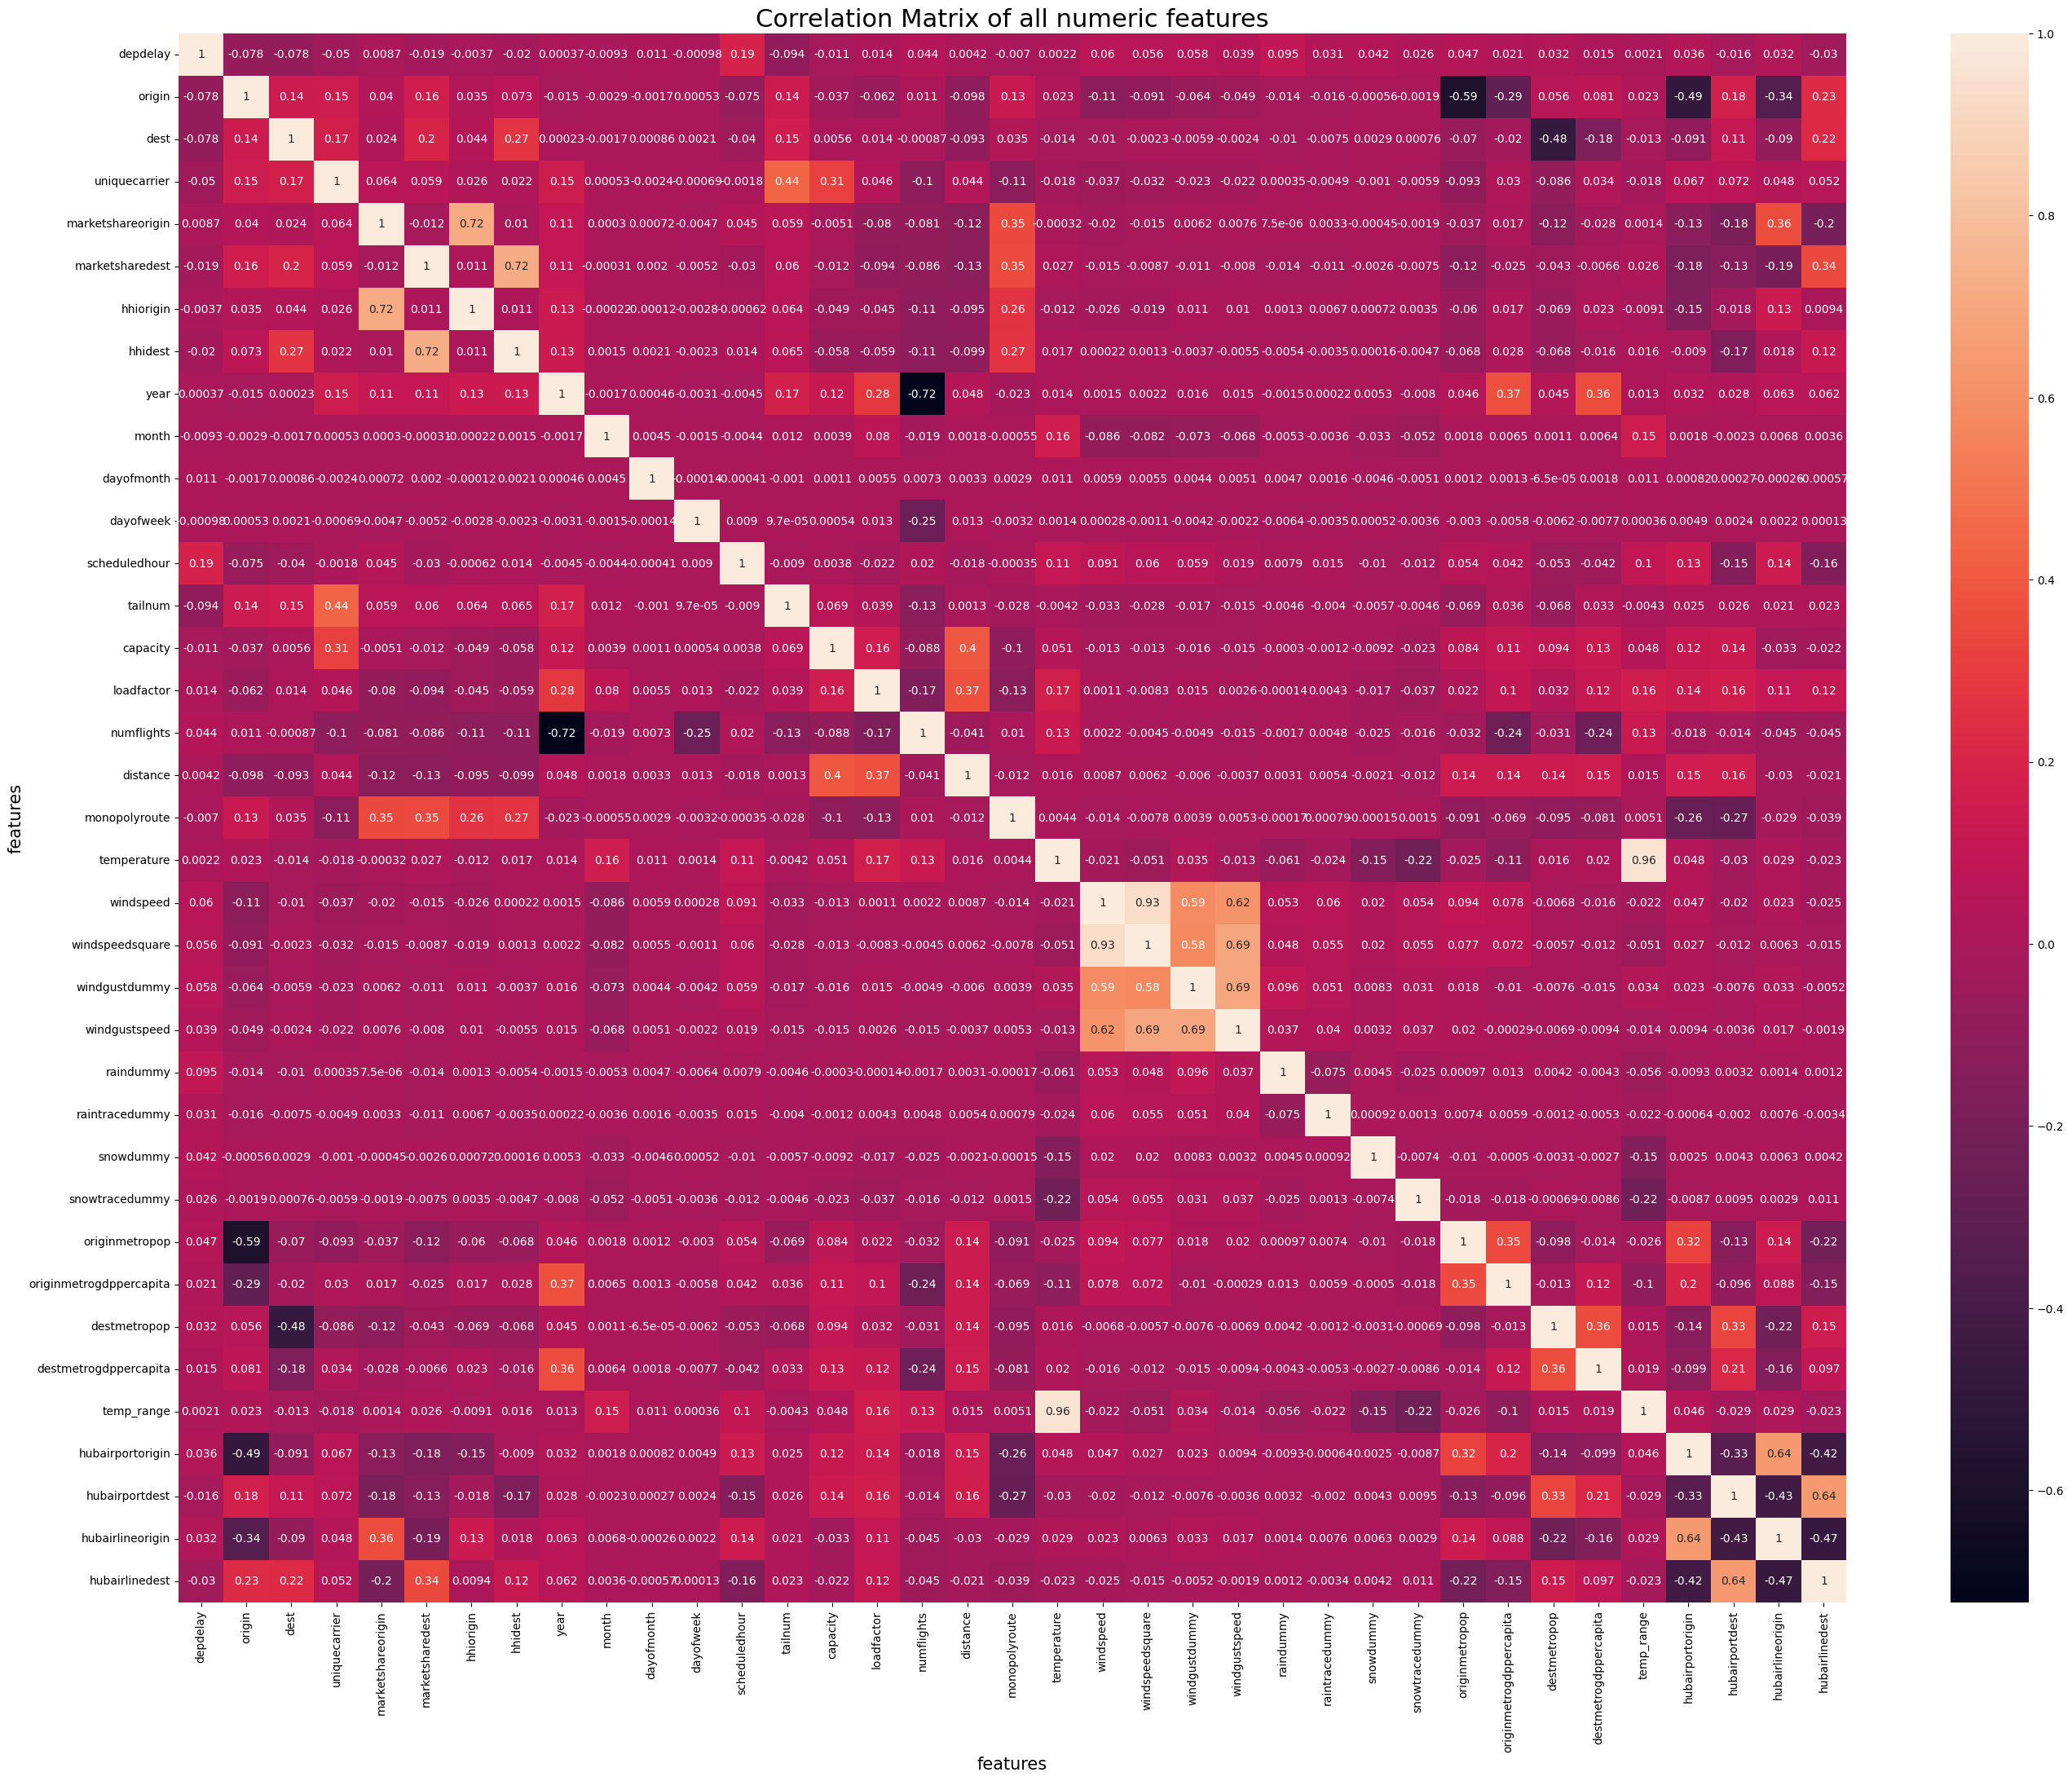

In [32]:
plt.figure(figsize = (33, 25))

sns.heatmap(flight_X_train.corr(), annot = True)
plt.xlabel("features", fontsize = 15)
plt.ylabel("features", fontsize = 15)
plt.title("Correlation Matrix of all numeric features", fontsize=22)
plt.savefig('correlation_heatmap.pdf')
plt.show()

- The `depdelay` has slight positive correlation of 0.19 with `scheduledhour`. This makes sense because the air traffic at the `scheduledhour` decides whether the ATC gives permission for aircraft to depart.
- Moreover, there is very slight correlation with the columns pertaining to weather. This also makes sense since the weather (visibility) at departure decides whether the plane can take-off or not.
- There is positive correlation of 0.44 between `tailnum` and `uniquecarrier` since a particular aircraft is owned by a particular carrier. Hence, that correlation does make sense.
- All the weather columns have some relation with each other.
- The `temperature` and `temp_range` have a very high positive correlation of 0.96 and it does make sense as well. Therefore, one of the columns needs to be dropped.
- On similar lines, `windspeed` and `windspeedsquare` have very high positive correlation of 0.93 and hence one of them needs to be dropped.
- The `capacity` and `loadfactor` have a positive correlation of approximately 0.40 with the `distance`. This makes sense because long-haul routes generally have higher `capacity` and a higher payload resulting a higher `loadfactor`.
- Not all values in the matrix make sense. They arise as an artifact of the data but do not make sense at all.

In [33]:
flight_X_train = flight_X_train.drop(["windspeedsquare", "temperature"], axis = 1)
flight_X_test = flight_X_test.drop(["windspeedsquare", "temperature"], axis = 1)

- I dropped `windspeedsquare` since `windspeed` is more intuitive to understand and explain the models that will be trained later.
- The `temperature` column is dropped. This is because the target is a range of delay and keep the `temp_range` might help instead of actual value of temperature.

In [34]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1198458 entries, 0 to 1201663
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   depdelay                 1198458 non-null  object 
 1   origin                   1198458 non-null  object 
 2   dest                     1198458 non-null  object 
 3   uniquecarrier            1198458 non-null  object 
 4   marketshareorigin        1198458 non-null  float64
 5   marketsharedest          1198458 non-null  float64
 6   hhiorigin                1198458 non-null  float64
 7   hhidest                  1198458 non-null  float64
 8   year                     1198458 non-null  int64  
 9   month                    1198458 non-null  int64  
 10  dayofmonth               1198458 non-null  int64  
 11  dayofweek                1198458 non-null  int64  
 12  scheduledhour            1198458 non-null  int64  
 13  tailnum                  1198458 non-null  obje

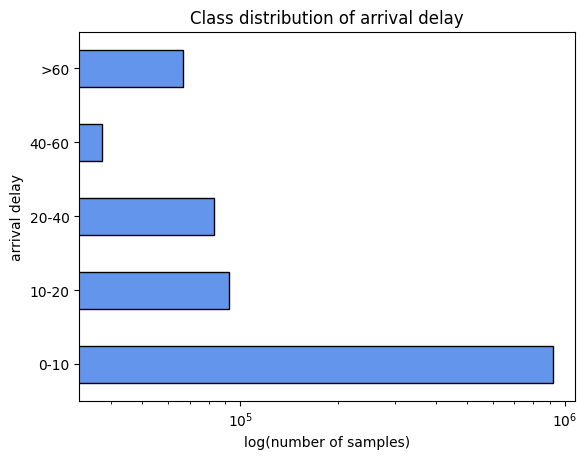

In [35]:
flight_y.value_counts().sort_index().plot(kind = "barh",
                             logx = True,
                             title = "Class distribution of arrival delay",
                             ylabel = "arrival delay",
                             xlabel = "log(number of samples)",
                             color = ["cornflowerblue"],
                             edgecolor = "k")
#plt.yticks([i for i in range(5)], ['0-10', '10-20', '20-40', '40-60', '>60'])
plt.show()

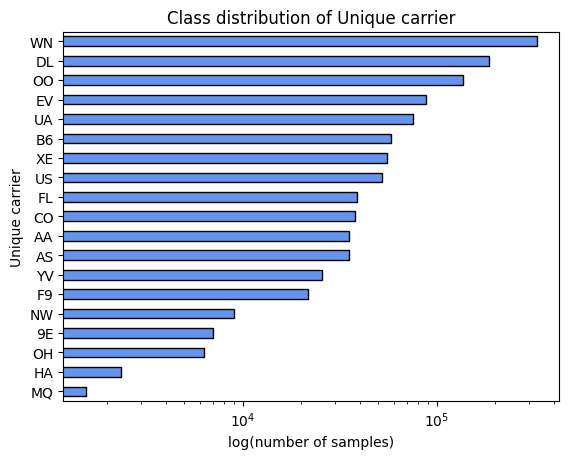

In [36]:
flight_df.uniquecarrier.value_counts().sort_values().plot(kind = "barh",
                             logx = True,
                             title = "Class distribution of Unique carrier",
                             ylabel = "Unique carrier",
                             xlabel = "log(number of samples)",
                             color = ["cornflowerblue"],
                             edgecolor = "k")
#plt.yticks([i for i in range(5)], ['0-10', '10-20', '20-40', '40-60', '>60'])
plt.show()

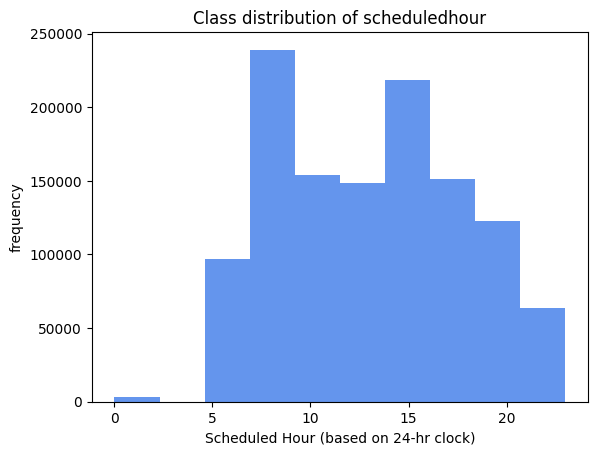

In [37]:
flight_df.scheduledhour.plot(kind = "hist",
                             title = "Class distribution of scheduledhour",
                             xlabel = "Scheduled Hour (based on 24-hr clock)",
                             ylabel = "frequency",
                             color = ["cornflowerblue"])
#plt.yticks([i for i in range(5)], ['0-10', '10-20', '20-40', '40-60', '>60'])
plt.show()

# Model Training

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [39]:
class Model:
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.train_pred = None
        self.test_pred = None
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        self.train_pred = self.model.predict(self.X_train)
        self.test_pred = self.model.predict(self.X_test)
        
        f1_score_train = f1_score(self.y_train, self.train_pred,
                                  average = "weighted")
        f1_score_test = f1_score(self.y_test, self.test_pred,
                                 average = "weighted")
        
        print("F1-score on train dataset =", f1_score_train)
        print("F1-score on test dataset =", f1_score_test)

## Original dataset

### Decision Tree

In [40]:
dtc = Model(model = DecisionTreeClassifier(),
            X_train = flight_X_train,
            y_train = flight_y_train,
            X_test = flight_X_test,
            y_test = flight_y_test)

In [41]:
dtc.train()
dtc.evaluate()

F1-score on train dataset = 1.0
F1-score on test dataset = 0.7693684159175935


In [42]:
print(classification_report(dtc.y_test, dtc.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

        0-10     0.9007    0.8839    0.8922    183773
       10-20     0.1705    0.1927    0.1809     18537
       20-40     0.2984    0.3134    0.3057     16565
       40-60     0.2621    0.2770    0.2693      7494
         >60     0.7587    0.7446    0.7516     13323

    accuracy                         0.7643    239692
   macro avg     0.4781    0.4823    0.4799    239692
weighted avg     0.7747    0.7643    0.7694    239692



The decision tree model is overfitted since there is a perfect F1-score on the train dataset but a drastically lower score of 0.7688 on the test dataset.

In [43]:
param_grid = {
    "max_depth": [8, 12, 16],
    "class_weight": [None, "balanced"],
    "max_features": [5, 10, 15]
}

dtc_gs = Model(model = GridSearchCV(DecisionTreeClassifier(), 
                                 param_grid),
               X_train = flight_X_train,
               y_train = flight_y_train,
               X_test = flight_X_test,
               y_test = flight_y_test)

In [44]:
dtc_gs.train()
dtc_gs.evaluate()

F1-score on train dataset = 0.8271108377291809
F1-score on test dataset = 0.8172117006594027


In [45]:
print("Best Parameters: ")
print(dtc_gs.model.best_params_)

Best Parameters: 
{'class_weight': None, 'max_depth': 12, 'max_features': 15}


In [47]:
print(classification_report(dtc_gs.y_test, dtc_gs.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

        0-10     0.8937    0.9842    0.9368    183773
       10-20     0.3367    0.0465    0.0817     18537
       20-40     0.4760    0.4654    0.4706     16565
       40-60     0.4830    0.3539    0.4085      7494
         >60     0.8606    0.8440    0.8522     13323

    accuracy                         0.8483    239692
   macro avg     0.6100    0.5388    0.5500    239692
weighted avg     0.8071    0.8483    0.8172    239692



- It is observed that the precision and recall for "0-10" and ">60" is high while that for the other classes such as "10-20" is very low.
- The imbalance in the data significantly impacting the performance of the model.

### Random Forest

In [48]:
rfc = Model(model = RandomForestClassifier(),
            X_train = flight_X_train,
            y_train = flight_y_train,
            X_test = flight_X_test,
            y_test = flight_y_test)

In [49]:
rfc.train()
rfc.evaluate()

F1-score on train dataset = 0.9999666217960089
F1-score on test dataset = 0.815201325142899


In [50]:
print(classification_report(rfc.y_test, rfc.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

        0-10     0.8911    0.9877    0.9369    183773
       10-20     0.3651    0.0382    0.0692     18537
       20-40     0.4738    0.4889    0.4812     16565
       40-60     0.5129    0.2486    0.3349      7494
         >60     0.8600    0.8593    0.8597     13323

    accuracy                         0.8496    239692
   macro avg     0.6206    0.5246    0.5364    239692
weighted avg     0.8080    0.8496    0.8152    239692



The decision model is overfitted since there is a nearly perfect F1-score on the train dataset but a drastically lower score of 0.8137 on the test dataset.

In [51]:
param_grid = {
    "max_depth": [8, 10, 12]
}

rfc_rs = Model(model = GridSearchCV(RandomForestClassifier(), 
                                    param_grid),
               X_train = flight_X_train,
               y_train = flight_y_train,
               X_test = flight_X_test,
               y_test = flight_y_test)

In [52]:
rfc_rs.train()
rfc_rs.evaluate()

F1-score on train dataset = 0.8084720489428499
F1-score on test dataset = 0.8019367820624718


In [53]:
print(classification_report(rfc_rs.y_test, rfc_rs.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

        0-10     0.8896    0.9890    0.9367    183773
       10-20     0.0000    0.0000    0.0000     18537
       20-40     0.4470    0.5869    0.5075     16565
       40-60     0.4672    0.0152    0.0295      7494
         >60     0.8575    0.8625    0.8600     13323

    accuracy                         0.8472    239692
   macro avg     0.5323    0.4907    0.4667    239692
weighted avg     0.7752    0.8472    0.8019    239692



- This model does not learn the "10-20" at all. Moreover, it does not learn the minority class ("40-60") either.
- While, it learns the majority class (0-10) very well but a delay less than 10 minutes is insignificant to the operations of an airlines and does not account for delay as per FAA.

### Gradient Boosting Tree

In [54]:
gbt = Model(model = GradientBoostingClassifier(),
            X_train = flight_X_train,
            y_train = flight_y_train,
            X_test = flight_X_test,
            y_test = flight_y_test)

In [55]:
gbt.train()
gbt.evaluate()

F1-score on train dataset = 0.8172730065014747
F1-score on test dataset = 0.8165077336311016


In [56]:
print(classification_report(gbt.y_test, gbt.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

        0-10     0.8929    0.9869    0.9376    183773
       10-20     0.3636    0.0177    0.0337     18537
       20-40     0.4786    0.4720    0.4753     16565
       40-60     0.4980    0.4194    0.4553      7494
         >60     0.8728    0.8540    0.8633     13323

    accuracy                         0.8512    239692
   macro avg     0.6212    0.5500    0.5530    239692
weighted avg     0.8099    0.8512    0.8165    239692



- The gradient boosting tree model is not overfitted since the performance on train dataset is mimicked well on the test dataset.
- This model does not require hyperparameter tuning because it is performing well on the test dataset.
- It learns minority classes better than Random Forest classifier.

## Histogram Gradient Boosting Trees

In [57]:
hbt = Model(model = HistGradientBoostingClassifier(),
            X_train = flight_X_train,
            y_train = flight_y_train,
            X_test = flight_X_test,
            y_test = flight_y_test)

In [58]:
hbt.train()
hbt.evaluate()

F1-score on train dataset = 0.8191206769731472
F1-score on test dataset = 0.8165100777675791


In [59]:
print(classification_report(hbt.y_test, hbt.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

        0-10     0.8921    0.9874    0.9373    183773
       10-20     0.3964    0.0215    0.0407     18537
       20-40     0.4818    0.4787    0.4802     16565
       40-60     0.5060    0.3851    0.4373      7494
         >60     0.8669    0.8548    0.8608     13323

    accuracy                         0.8513    239692
   macro avg     0.6286    0.5455    0.5513    239692
weighted avg     0.8120    0.8513    0.8165    239692



- This model is not overfitted since the performance on train dataset is mimicked well on the test dataset.
- It does not require hyperparameter tuning because it is performing well on the test dataset.
- It learns minority classes better than Random Forest classifier.
- It trains much faster than other models (by observation).

### Feature importances (log scale)

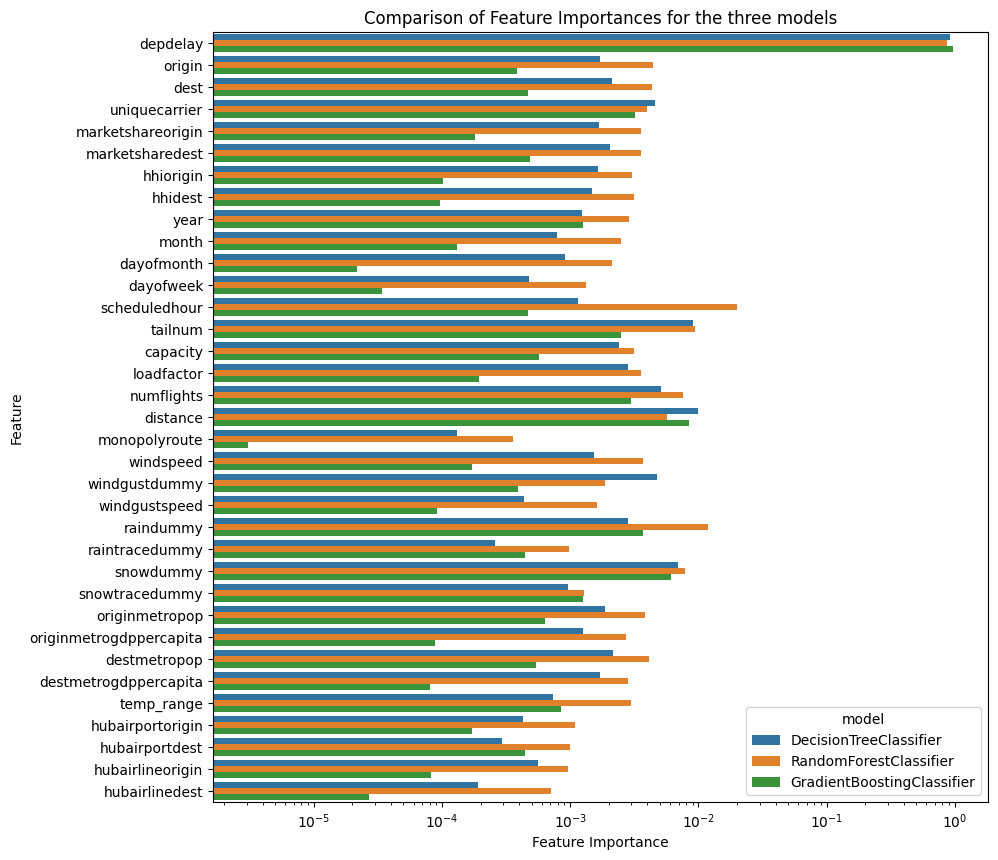

In [61]:
f_imp_dtc = dtc_gs.model.best_estimator_.feature_importances_
f_imp_rfc = rfc_rs.model.best_estimator_.feature_importances_
f_imp_gdc = gbt.model.feature_importances_
cols = list(flight_X_train.columns)

f_imp_dict = {
    "feature_imp": list(f_imp_dtc) + list(f_imp_rfc) + list(f_imp_gdc),
    "model": ["DecisionTreeClassifier"]*len(cols) + ["RandomForestClassifier"]*len(cols) + ["GradientBoostingClassifier"]*len(cols),
    "column": cols + cols + cols
}

f_imp = pd.DataFrame(f_imp_dict)


plt.figure(figsize = (10, 10))
sns.barplot(data = f_imp, y = "column", x = "feature_imp", hue = "model")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Comparison of Feature Importances for the three models")
plt.xscale("log")
plt.savefig('feature_importance_comparison.pdf')
plt.show()

- As expected, the `depdelay` is the most important feature for the three models.
- The `scheduledhour` is also another important feature for Decision Tree and Random Forest. It does make sense since the air traffic at a particular hour can affect the time at which the aircraft is permitted to land.
- All the three models find `distance` ,`raindummy`and `snowdummy` important. Considering `raindummy` and `snowdummy` is valid since it is a weather-based factor that affects the visibility and the runway condition. 

## Re-binning based on some observation

- In the real-world, a delay between 0 to 10 minutes is insignificant and flight is not considered to be delayed in that range.
- Since, the aim of this project is to classify the arrival delay, we can ignore that category and focus the model on actually detecting significant ranges of delays.
- Morever, we also combine the bins for "40-60" and ">60" into one bin of ">40".
- The above bins are combined because in reality there is not much difference in the patterns for delay beyond 40 minutes.

In [62]:
arrdelay_rep = {"40-60": ">40", ">60":">40"}

flight_X_train = flight_X_train[flight_y_train != "0-10"]
flight_y_train = pd.Series(flight_y_train)[flight_y_train != "0-10"].replace(arrdelay_rep)

flight_X_test = flight_X_test[flight_y_test != "0-10"]
flight_y_test = pd.Series(flight_y_test)[flight_y_test != "0-10"].replace(arrdelay_rep)

## Decision Tree Classifier

In [63]:
param_grid = {
    "max_depth": [8, 12, 20],
    "max_features": [10, 15]
}

dtc_gs = Model(model = GridSearchCV(DecisionTreeClassifier(), 
                                 param_grid),
               X_train = flight_X_train,
               y_train = flight_y_train,
               X_test = flight_X_test,
               y_test = flight_y_test)

In [64]:
dtc_gs.train()

In [65]:
dtc_gs.evaluate()

F1-score on train dataset = 0.6988486377072638
F1-score on test dataset = 0.6924072383940221


In [66]:
print(classification_report(dtc_gs.y_test, dtc_gs.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

       10-20     0.6445    0.7492    0.6929     18537
       20-40     0.5430    0.4669    0.5021     16565
         >40     0.8579    0.8294    0.8434     20817

    accuracy                         0.6954     55919
   macro avg     0.6818    0.6818    0.6795     55919
weighted avg     0.6939    0.6954    0.6924     55919



- Now, the models learn all the classes more uniformly compared to that on the original dataset.
- The macro-avg metrics improve significantly here showing each class was learnt uniformly.

### Random Forest

In [67]:
param_grid = {
    "max_depth": [8, 12, 16],
    "max_features": [5, 10, 15]
}

rfc_rs = Model(model = GridSearchCV(RandomForestClassifier(),
                                    param_grid),
               X_train = flight_X_train,
               y_train = flight_y_train,
               X_test = flight_X_test,
               y_test = flight_y_test)

In [68]:
rfc_rs.train()
rfc_rs.evaluate()

F1-score on train dataset = 0.7213327804798596
F1-score on test dataset = 0.6956656120798984


In [69]:
print(classification_report(rfc_rs.y_test, rfc_rs.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

       10-20     0.6436    0.7575    0.6959     18537
       20-40     0.5517    0.4665    0.5055     16565
         >40     0.8620    0.8321    0.8468     20817

    accuracy                         0.6990     55919
   macro avg     0.6858    0.6853    0.6827     55919
weighted avg     0.6977    0.6990    0.6957     55919



- Unlike the performance on the original dataset, the random forest learns the "10-20" category much better.
- There is a subtle improvement from the decision tree.

## Gradient Boosting Trees

In [70]:
gbt = Model(model = GradientBoostingClassifier(),
            X_train = flight_X_train,
            y_train = flight_y_train,
            X_test = flight_X_test,
            y_test = flight_y_test)

In [71]:
gbt.train()
gbt.evaluate()

F1-score on train dataset = 0.6963346910958372
F1-score on test dataset = 0.6945390049554364


In [72]:
print(classification_report(gbt.y_test, gbt.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

       10-20     0.6419    0.7593    0.6957     18537
       20-40     0.5536    0.4596    0.5023     16565
         >40     0.8587    0.8348    0.8465     20817

    accuracy                         0.6986     55919
   macro avg     0.6847    0.6846    0.6815     55919
weighted avg     0.6964    0.6986    0.6945     55919



The performance is very similar to that of random forest.

## Histogram Gradient Boosting Trees

In [73]:
hbt = Model(model = HistGradientBoostingClassifier(),
            X_train = flight_X_train,
            y_train = flight_y_train,
            X_test = flight_X_test,
            y_test = flight_y_test)

In [74]:
hbt.train()
hbt.evaluate()

F1-score on train dataset = 0.7044332725618271
F1-score on test dataset = 0.6967545356382973


In [75]:
print(classification_report(hbt.y_test, hbt.test_pred,
                            digits = 4))

              precision    recall  f1-score   support

       10-20     0.6443    0.7550    0.6953     18537
       20-40     0.5512    0.4744    0.5099     16565
         >40     0.8654    0.8288    0.8467     20817

    accuracy                         0.6994     55919
   macro avg     0.6870    0.6861    0.6840     55919
weighted avg     0.6990    0.6994    0.6968     55919



- This model is not overfitted since the performance on train dataset is mimicked well on the test dataset.
- It does not require hyperparameter tuning because it is performing well on the test dataset.
- This model performs slightly better than random forest and even trains faster (by observation).

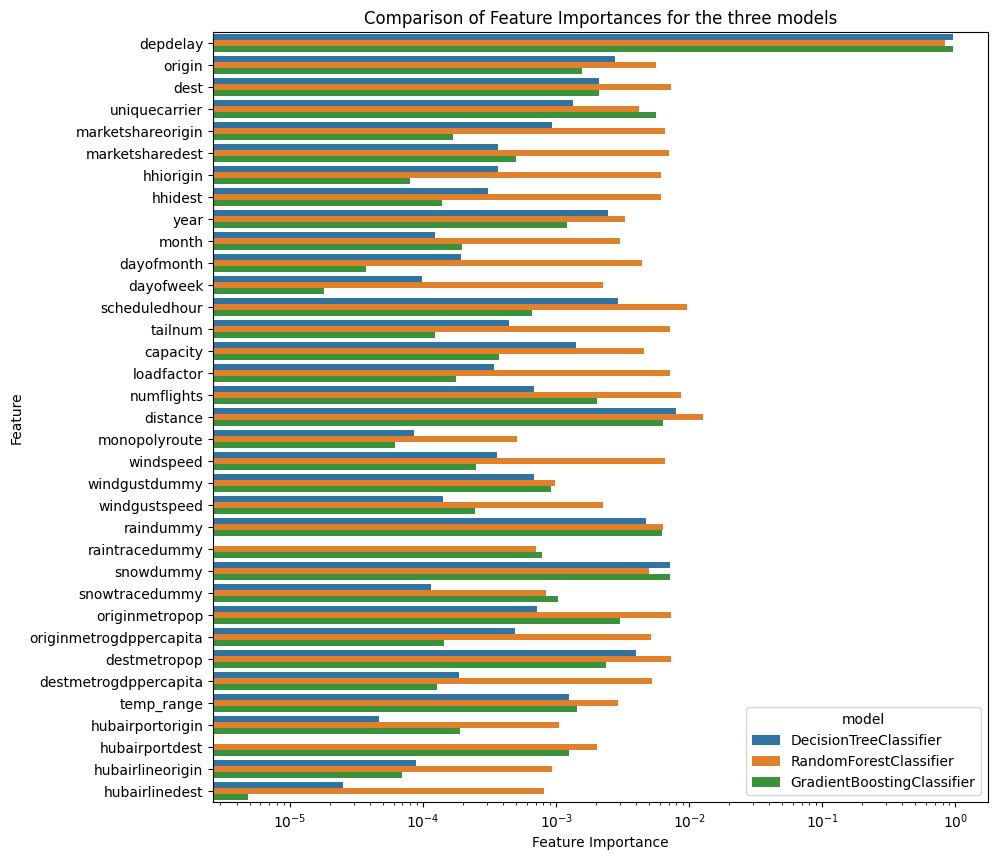

In [76]:
f_imp_dtc = dtc_gs.model.best_estimator_.feature_importances_
f_imp_rfc = rfc_rs.model.best_estimator_.feature_importances_
f_imp_gdc = gbt.model.feature_importances_
cols = list(flight_X_train.columns)

f_imp_dict = {
    "feature_imp": list(f_imp_dtc) + list(f_imp_rfc) + list(f_imp_gdc),
    "model": ["DecisionTreeClassifier"]*len(cols) + ["RandomForestClassifier"]*len(cols) + ["GradientBoostingClassifier"]*len(cols),
    "column": cols + cols + cols
}

f_imp = pd.DataFrame(f_imp_dict)


plt.figure(figsize = (10, 10))
sns.barplot(data = f_imp, y = "column", x = "feature_imp", hue = "model")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Comparison of Feature Importances for the three models")
plt.xscale("log")
plt.savefig('feature_importance_comparison.pdf')
plt.show()

- Here, as well, `depdelay` is the most important feature for all the three models.
- Few features such as `distance` have gained higher importance after re-binning the arrival delay.
- Relatively, it seems like `monopolyroute` is the least important feature for all models.

## Conclusion

- After binning the data, all the models learn every class more uniformly.
- From the feature importances, it is evident that a flight departing late is the most common reason behind flight delays.
- However, there are other factors as well but they erratic. For example, `snowdummy` is only relevant for the winter months.
- On the other hand, the rains in most states are not seasonal and hence features `raindummy` impact only in fewer cases.
- This is the reason why most features have `log(feature_importances) < 0.01`.
- Overall, flight delay prediction is a very tedious task since there are many factors that account for it and it makes the feature space more complicated.
- Hence, learning decision boundaries becomes very hard especially for multiclass classification.